# Accuracy Explained


# I. Import data

### Load Libraries

In [41]:
%reset
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # pip install seaborn

sns.set(style="whitegrid", color_codes=True)
pd.set_option('display.max_columns', None)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Load CSV

In [61]:
df = pd.read_csv('train.csv', header=0,sep=',')

In [62]:
#different place_id
len(df['place_id'].unique())

108390

# II. Data Exploration 

In [63]:
df_cl = df.copy()

#### Data viz

#### Number of event in function of time

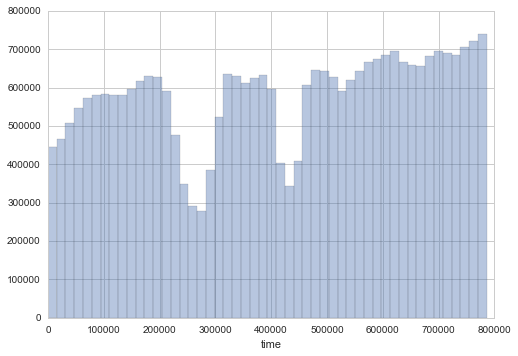

In [65]:
ax = sns.distplot(df_cl["time"], kde=False)

#### Number of event in function of accuracy

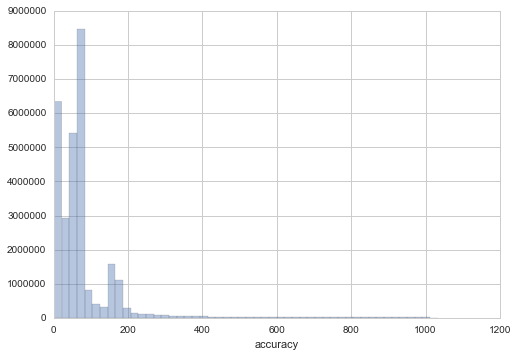

In [66]:
ax = sns.distplot(df_cl["accuracy"], kde=False)

### Is accuracy linked to distance with place_id's center ?

In [67]:
aggregation = {
    'x' : {
        'median_x' : 'median',
        'mean_x' : 'mean',
        'variance_x' : 'var' 
    },
    'y' : {
        'median_y' : 'median',
        'mean_y' : 'mean',
        'var_y' : 'var'
    }
}
df_cl_agg = df_cl.groupby("place_id").agg(aggregation)

In [68]:
df_cl_agg.columns = df_cl_agg.columns.droplevel()

In [69]:
df_cl_agg.head()

,mean_y,var_y,median_y,variance_x,median_x,mean_x
place_id,,,,,,
1000015801,5.549160,0.000255,5.54925,0.043412,2.69150,2.671644
1000017288,4.346527,0.000105,4.34700,0.114724,7.10790,7.336637
1000025138,5.570373,0.000104,5.56990,0.005780,0.98280,0.991042
1000052096,5.833414,0.000128,5.83390,0.224639,2.80640,2.856777
1000063498,7.566078,0.005446,7.55045,2.319981,4.02725,4.054855


In [70]:
result = pd.merge(df_cl, df_cl_agg, left_on='place_id', right_index=True, how='inner', suffixes=('_left', '_right'))

In [71]:
result.sort_values(by = "row_id", inplace=True)

In [72]:
result.head()

,row_id,x,y,accuracy,time,place_id,mean_y,var_y,median_y,variance_x,median_x,mean_x
0,0,0.7941,9.0809,54,470702,8523065625,9.080389,0.000152,9.0807,0.805150,0.79630,0.908878
1,1,5.9567,4.7968,13,186555,1757726713,4.806560,0.000936,4.8071,0.291482,5.98835,5.909088
2,2,8.3078,7.0407,74,322648,1137537235,7.037016,0.000201,7.0345,1.094584,8.61660,8.399515
3,3,7.3665,2.5165,65,704587,6567393236,2.509538,0.000223,2.5101,0.911392,6.69530,6.554827
4,4,4.0961,1.1307,31,472130,7440663949,1.169124,0.001481,1.1593,4.453357,9.74880,8.483354


#####  Distance of each point with the center of its place_id (euclidian)

In [73]:
result["distance_median"] = np.sqrt( np.power((result["median_y"]-result["y"]), 2) + np.power((result["median_x"]-result["x"]), 2) )

In [60]:
df_acc_dist = pd.DataFrame(result.groupby("accuracy")["distance_median"].mean())

In [74]:
df_acc_dist.head()

,distance_median
accuracy,
1,0.376017
2,0.371154
3,0.373000
4,0.368361
5,0.382076


(0, 0.6)

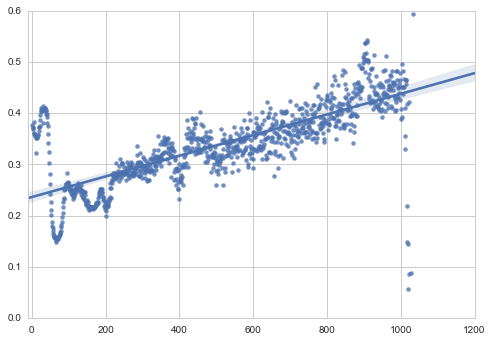

In [75]:
ax = sns.regplot(x=np.asarray(df_acc_dist.index), y=np.asarray(df_acc_dist.distance_median))
ax.set_xlim(-10,1200)
ax.set_ylim(0,0.6)

Accuracy is linked to distance when accuracy is higher than 200. However, the majority of our event has an accuracy lower than 200. We couldn't explain the accuracy thanks to distance.

In [76]:
df.loc[df_cl["accuracy"] > 200].shape

(1554504, 6)

##### Is accuracy linked to location ? 

We split the space by 100 in x, and 100 in y.

In [77]:
bins_value = np.arange(0,10,0.1)
group_names = np.arange(0,9.9,0.1).astype('str')

In [78]:
df_cl["x_bin"] = pd.cut(df_cl["x"], bins=bins_value, labels=group_names)
df_cl["y_bin"] = pd.cut(df_cl["y"], bins=bins_value, labels=group_names)

We compute the accuracy's median for each cell of the space.

In [79]:
df_tmp = pd.DataFrame(df_cl.groupby(["x_bin", "y_bin"])["accuracy"].median()).reset_index()

In [80]:
df_pivot = df_tmp.pivot("x_bin","y_bin","accuracy")

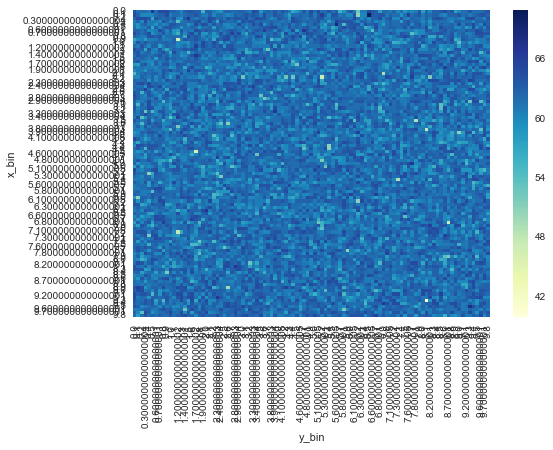

In [81]:
ax = sns.heatmap(df_pivot, cmap="YlGnBu")

Conclusion : Accuracy don't depend of the location

### Feature engineering

Time columns is not a timestamp but just an integer

In [82]:
df_cl["minutes"] = df["time"]%60
df_cl["hours"] = (df['time']//60) % 24
df_cl["weekday"] = (df['time']//60 * 24) % 7
df_cl["month"] = df['time']//(60*24*30) % 12
df_cl["year"] = df['time']//(60*24*365)
df_cl["yearday"] = df['time']//(60*24) % 365
df_cl["day_number"] = df['time']//(60*24) % 1000

In [83]:
df_cl.head()

,row_id,x,y,accuracy,time,place_id,x_bin,y_bin,minutes,hours,weekday,month,year,yearday,day_number
0,0,0.7941,9.0809,54,470702,8523065625,0.7000000000000001,9.0,2,21,1,10,0,326,326
1,1,5.9567,4.7968,13,186555,1757726713,5.9,4.7,15,13,3,4,0,129,129
2,2,8.3078,7.0407,74,322648,1137537235,8.3,7.0,28,1,3,7,0,224,224
3,3,7.3665,2.5165,65,704587,6567393236,7.300000000000001,2.5,7,7,5,4,1,124,489
4,4,4.0961,1.1307,31,472130,7440663949,4.0,1.1,50,20,0,10,0,327,327


##### Some plot 

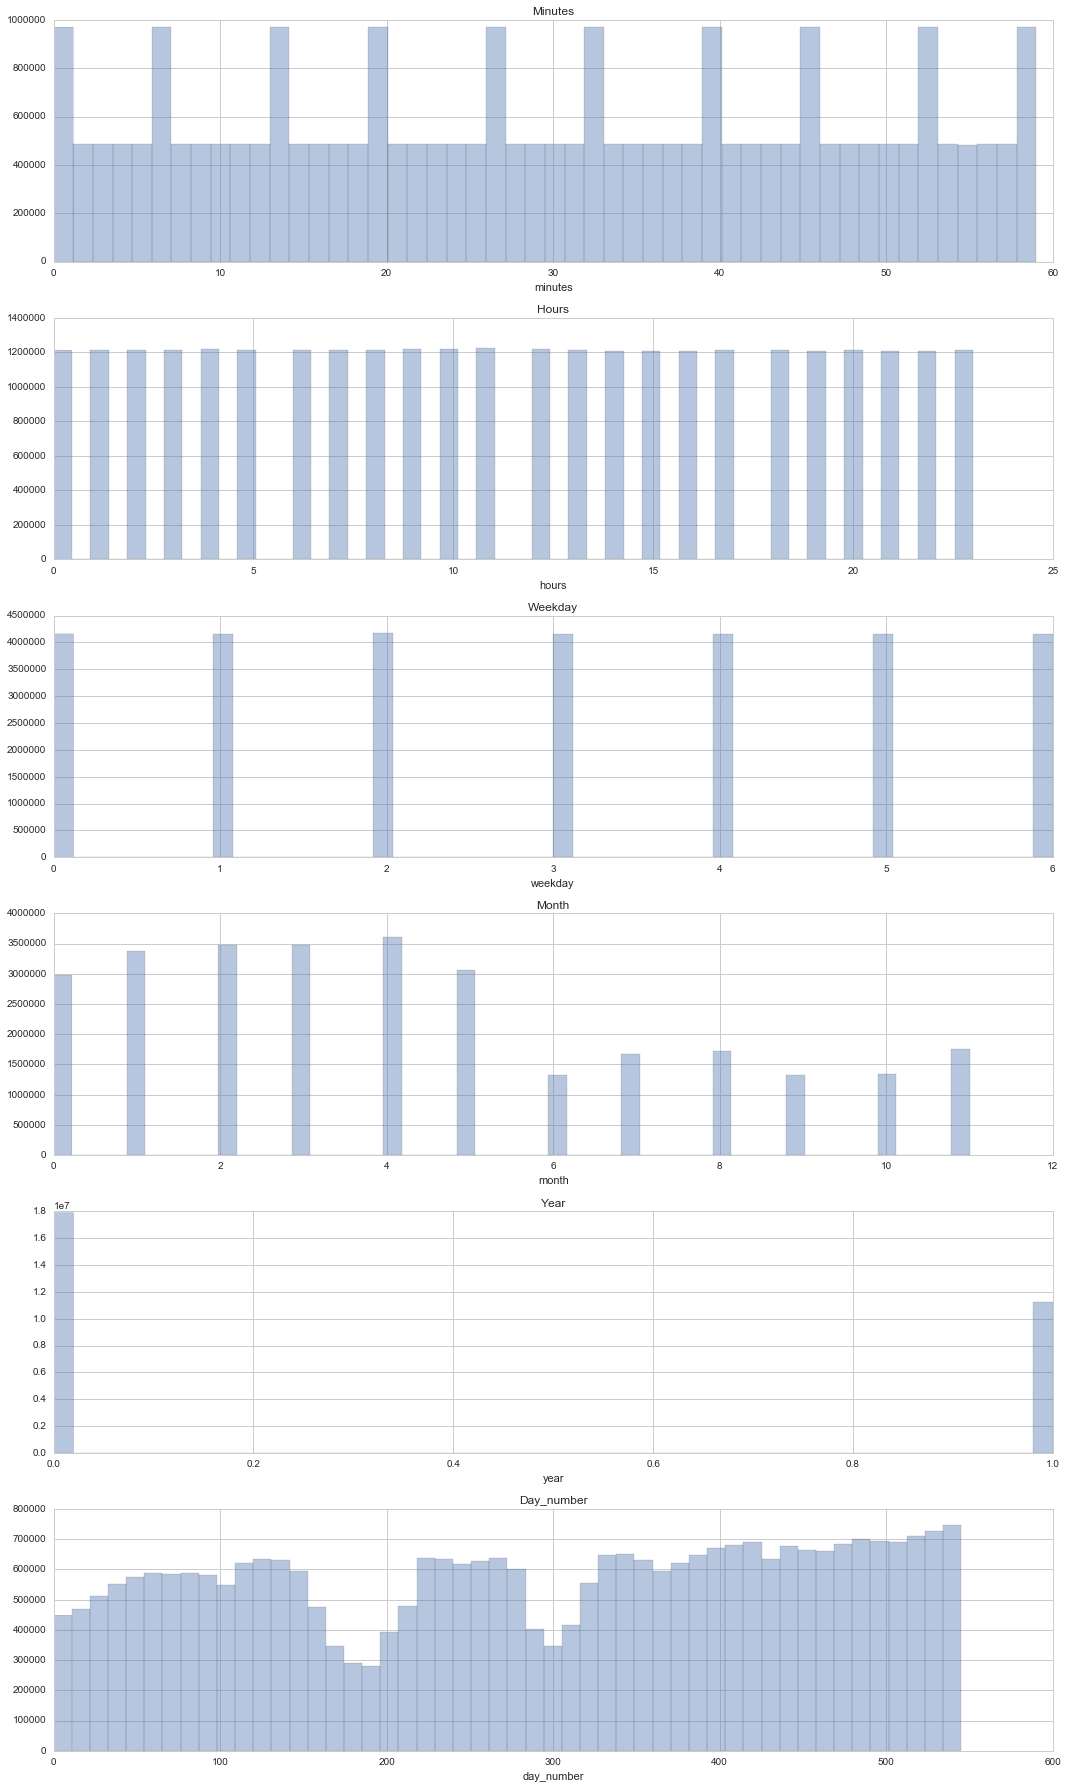

In [85]:
f, axarr = plt.subplots(6, figsize=(15, 25))

sns.distplot(df_cl["minutes"], kde=False, ax=axarr[0])
sns.distplot(df_cl["hours"], kde=False, ax=axarr[1])
sns.distplot(df_cl["weekday"], kde=False, ax=axarr[2])
sns.distplot(df_cl["month"], kde=False, ax=axarr[3])
sns.distplot(df_cl["year"], kde=False, ax=axarr[4])
sns.distplot(df_cl["day_number"], kde=False, ax=axarr[5])

axarr[0].set_title('Minutes')
axarr[1].set_title('Hours')
axarr[2].set_title('Weekday')
axarr[3].set_title('Month')
axarr[4].set_title('Year')
axarr[5].set_title('Day_number')

plt.tight_layout()
plt.show()

###### Is Accuracy linked with time ?

In [86]:
df_agg_d_acc = pd.DataFrame(df_cl.groupby("day_number")["accuracy"].mean()).reset_index()

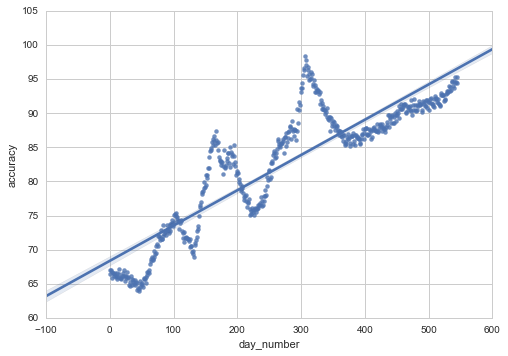

In [87]:
ax = sns.regplot(x="day_number", y="accuracy", data=df_agg_d_acc)

###### Number of event per day

In [88]:
df_agg_d_count = pd.DataFrame(df_cl.groupby("day_number")["row_id"].count()).reset_index()

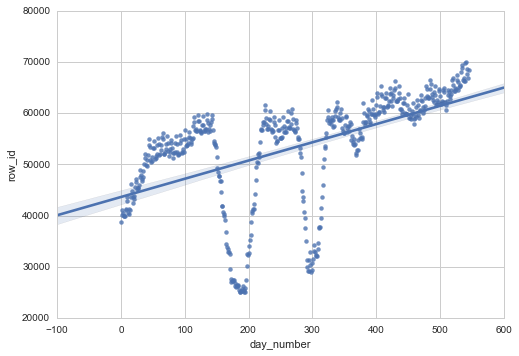

In [89]:
ax = sns.regplot(x="day_number", y="row_id", data=df_agg_d_count)

**Conclusion**: We saw on the last 2 graphs that when there are few events per day the accuracy is high and it is the opposite when there are a lot of events per day.<br>
I think that when there are a lot of people who try to access to the network in same time, the relay mast are saturated and must dispatch the signals to others relays. The others relays are far away from you and it has more difficulty to locate you precisly. That's why the accuracy go down.

#### Conclusion : Accuracy depends on number of people who try to connect to locate them at the same time